# Особенности посторения процесса обучения нейронной сети

Больше о настройке обучения нейронных сетей можно найти, например, в:
* [A Recipe for Training Neural Networks](https://karpathy.github.io/2019/04/25/recipe/) 
* и в других тематических публикациях известных специалистов, [например](https://sebastianraschka.com/blog/2023/pytorch-faster.html), а также официальные публикации `PyTorch`, [например](https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html), и известные коллекции примеров, [например](https://madewithml.com/).
* Важно также иметь в виду вопросы ускорения и вычислительной оптимизации обучения нейронных сетей, см., [например](https://habr.com/ru/companies/wunderfund/articles/820721/).
* А также важно иметь в виду вопросы настройки гиперпараметров обучения нейронных сетей, см., [например](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html) и [тут](https://docs.ray.io/en/latest/tune/getting-started.html) и [тут](https://docs.ray.io/en/latest/tune/examples/tune-pytorch-cifar.html).
 
<!-- [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1k5ih-FSbCTuErwBHHi3J3uCN1q4fRzFI) -->

## Импорт `torch`

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import os
import copy
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
from torchvision import transforms, datasets

from torchsummary import summary

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from tqdm.notebook import tqdm, trange

import pandas as pd

Настроим работу с `PyTorch`. Выбирем формат работы и устройство для работы.

In [2]:
def torch_stats(): 
    torch_version = ".".join(torch.__version__.split(".")[:2])
    print('torch version:',torch_version)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    dtype = torch.float32
    
    if device.type == 'cuda':
        cuda_version  = torch.__version__.split("+")[-1]
        print("cuda: ", cuda_version)
        
        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        print('Cuda is available:',torch.cuda.is_available())

        n_devices = torch.cuda.device_count()
        print('number of devices: %d'%(n_devices))

        for cnt_device in range(n_devices):
            print(torch.cuda.get_device_name(cnt_device))
            print('Memory Usage:')
            print('Allocated:', round(torch.cuda.memory_allocated(cnt_device)/1024**3,1), 'GB')
            print('Cached:   ', round(torch.cuda.memory_reserved(cnt_device)/1024**3,1), 'GB')


    torch.set_default_dtype(dtype) # float32
    print('default data type:',dtype)
    
    num_workers=os.cpu_count()
    print ('available number of workers:',num_workers)
    
    return device, dtype, num_workers
#-------------------------------
def torch_seed(seed = 42, deterministic = True):
    random.seed(seed) # random and transforms
    np.random.seed(seed) #numpy
    torch.manual_seed(seed) #cpu
    torch.cuda.manual_seed(seed) #gpu
    torch.backends.cudnn.deterministic=deterministic #cudnn    
    


In [3]:
device, dtype, num_workers = torch_stats()
torch_seed(seed = 42, deterministic = True)

torch version: 2.2
Using device: cpu
default data type: torch.float32
available number of workers: 8


# Загрузка набора данных

<!-- Рассмотрим набор данных [`CIFAR10`](https://www.cs.toronto.edu/~kriz/cifar.html), который в этот раз импортируется из пакета `torchvision.datasets`. Однако в отличии от классичесского рассмотрения тут мы преобразуем набор к уже изученному ранее формату векторов. Эту операцию можно проделать при помощи встроенных функций `torchvision`. -->
Рассмотрим набор данных [`FashionMNIST`](https://github.com/zalandoresearch/fashion-mnist), который в этот раз импортируется из пакета `torchvision.datasets`.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
transform_ = lambda x: x.flatten() / 255.0
transform=transforms.Compose([transforms.ToTensor(),
                             transform_, ])

При загрузке набора данных задаются стандартные преобразования `transforms`. Тренировочная часть и тестовая часть загружаются отдельно.

<blockquote>
    Если не удается скачать набор данных с ошбикой про ssl, то нужно раскомментировать код ниже.
</blockquote>

In [6]:
# import ssl
# ssl._create_default_https_context = ssl._create_stdlib_context

In [7]:
train_data = datasets.FashionMNIST('data', train=True,  download=True,  transform=transform)
test_data  = datasets.FashionMNIST('data', train=False, download=True, transform=transform)

Полученный набор данных представляет собой итерируемый объект. Доступ к отдельным элементам такого датасета может быть получен как для списка. Каждый элемент представляет собой изображение (в нашем случае — вектор) и его метку.

In [8]:
train_data[0][0].shape, train_data[0][1] 

(torch.Size([784]), 9)

In [9]:
# name_classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
name_classes = ['T-Shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']

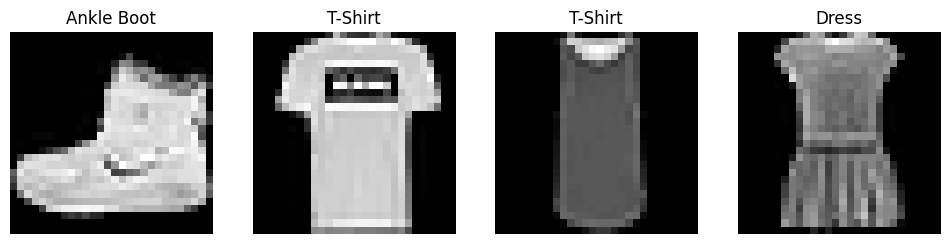

In [10]:
WIDTH = 28
HEIGH = 28
fig, axs = plt.subplots(1,4,figsize=(12,3));
axs[0].imshow(train_data[0][0].view(WIDTH,HEIGH), cmap='gray'); axs[0].set_title(name_classes[train_data[0][1]]); axs[0].axis('off')
axs[1].imshow(train_data[1][0].view(WIDTH,HEIGH), cmap='gray'); axs[1].set_title(name_classes[train_data[1][1]]); axs[1].axis('off')
axs[2].imshow(train_data[2][0].view(WIDTH,HEIGH), cmap='gray'); axs[2].set_title(name_classes[train_data[2][1]]); axs[2].axis('off')
axs[3].imshow(train_data[3][0].view(WIDTH,HEIGH), cmap='gray'); axs[3].set_title(name_classes[train_data[3][1]]); axs[3].axis('off')
plt.show()

Соотвественно можно узнать размер выборок

In [11]:
len(train_data), len(test_data)

(60000, 10000)

In [12]:
VALID_RATIO = 0.8

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = torch.utils.data.random_split(train_data, [n_train_examples, n_valid_examples])

print(f"Training data size : {len(train_data)}, Validation data size : {len(valid_data)}, Test data size : {len(test_data)}")

Training data size : 48000, Validation data size : 12000, Test data size : 10000


In [13]:
BATCH_SIZE = 64

train_loader = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

val_loader = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_loader = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

 
print(f"Training data batches : {len(train_loader)}, Validation data batches : {len(val_loader)}, Test data batches : {len(test_loader)}")


Training data batches : 750, Validation data batches : 188, Test data batches : 157


In [14]:
images, _ =  next(iter(train_loader))
images.shape


torch.Size([64, 784])

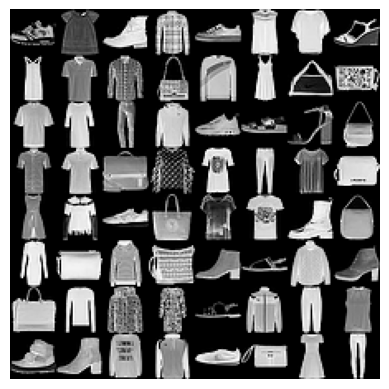

(torch.Size([64, 1, 28, 28]), torch.Size([3, 224, 224]), (224, 224, 3))

In [15]:
images = images.reshape(-1,1,28,28)
batch = torchvision.utils.make_grid(images, nrow = int(np.sqrt(images.shape[0])), padding = 0)
vis_batch = batch.data.numpy().transpose((1, 2, 0))*255
plt.imshow(vis_batch); 
plt.axis('off');
plt.show()
images.shape, batch.shape,  vis_batch.shape

## Тест сети

In [16]:
IMAGE_WIDTH = 28 
IMAGE_HEIGH = 28

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(IMAGE_WIDTH*IMAGE_HEIGH, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x  #log(softmax(x)) in loss assumed

In [17]:
def train(model, dataloader, optimizer, criterion, metric,  device):

    epoch_loss = 0
    epoch_acc  = 0

    model.train()

    for (x, y) in tqdm(dataloader, desc="Training", leave=False):

        x, y = x.to(device), y.to(device)

        optimizer.zero_grad(set_to_none = True)

        y_pred = model(x)

        loss = criterion(y_pred, y)
        acc  = metric(y_pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

def evaluate(model, dataloader, criterion, metric, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.eval()

    with torch.inference_mode():
        
        for (x, y) in tqdm(dataloader, desc="Evaluating", leave=False):

            x, y = x.to(device), y.to(device)

            y_pred = model.forward(x)

            loss = criterion(y_pred, y)
            acc  = metric( y_pred, y)

            epoch_loss += loss.item()
            epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [18]:
model = Model()
criterion = nn.CrossEntropyLoss()
metric = calculate_accuracy
model = model.to(device)
criterion = criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.05)

In [19]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, metric, device)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, metric, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%',
    f'| Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 4s
	Train Loss: 0.810 | Train Acc: 69.21% | Val. Loss: 0.611 | Val. Acc: 77.62%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 4s
	Train Loss: 0.562 | Train Acc: 79.76% | Val. Loss: 0.531 | Val. Acc: 81.32%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 4s
	Train Loss: 0.519 | Train Acc: 81.45% | Val. Loss: 0.526 | Val. Acc: 80.72%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 4s
	Train Loss: 0.493 | Train Acc: 82.46% | Val. Loss: 0.487 | Val. Acc: 83.15%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 4s
	Train Loss: 0.476 | Train Acc: 82.91% | Val. Loss: 0.504 | Val. Acc: 82.61%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 4s
	Train Loss: 0.459 | Train Acc: 83.66% | Val. Loss: 0.482 | Val. Acc: 83.64%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 4s
	Train Loss: 0.455 | Train Acc: 83.73% | Val. Loss: 0.604 | Val. Acc: 79.07%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 4s
	Train Loss: 0.452 | Train Acc: 83.93% | Val. Loss: 0.487 | Val. Acc: 82.90%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 4s
	Train Loss: 0.446 | Train Acc: 84.24% | Val. Loss: 0.455 | Val. Acc: 84.26%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 4s
	Train Loss: 0.439 | Train Acc: 84.42% | Val. Loss: 0.479 | Val. Acc: 83.10%


In [20]:
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(model, test_loader, criterion, metric, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.481 | Test Acc: 83.50%


# Приемы обучения НС

## Инициализация обучения

Для повышения качества работы с моделями проведем инициализацию весовых параметров при помощи модуля [`nn.init`](https://pytorch.org/docs/stable/nn.init.html).

> Отметим, что в ряде случаев достаточно инициализации «по умолчанию». В других случаях лучше проводить рекомендованные схемы инициализации. Однако, пробуя вручную различные схемы инициализации, мы обычно можем добиться небольшого улучшения производительности.

Инициализируем параметры, создавая функцию, которая принимает модуль (слой) модели, проверяет, какого типа этот слой, а затем использует методы `nn.init` для инициализации параметров рекомендуемым способом.

В достаточно общем случае можно сказать, что инициализация имеет вид нормального или равномерного распределений с параметром (стандартным отклонением или разбросом), заданным:

$$\frac{\text{gain}}{\sqrt{\text{fan mode}}}$$

Значение $\text{gain}$ зависит от нелинейности, которая будет использована после слоя. Например, `ReLU` устанавливает $\text{gain}$ в $\sqrt{2}$. Значение $\text{fan mode}$ может быть либо `fan_in`, либо `fan_out`. `fan_in` — это количество соединений, входящих в слой, а `fan_out` — количество соединений, выходящих из слоя. Количество соединений — это количество параметров (оно есть не только у полносвязного слоя, но и у остальных слоев). Для линейного слоя можно записать названную инициализацию как $$\frac{\text{2}}{\sqrt{\text{fan in}+\text{fan out}}}$$     
> Например, для сверточного слоя на вход поступает фильтр 3x3x3, поэтому `fan_in` равно 27, а на выход — 64x3x3, поэтому `fan_out` равно 576. Эта схема инициализации называется *Kaiming Normal*, также известная как *Xe Normal*.

В `nn.init` есть функция `calculate_gain`, которая рассчитывает $\text{gain}$ для заданных функций активации.

При инициализации — инициализируем члены смещения нулями.

> Зачем вообще нужно инициализировать параметры? Мы хотим, чтобы выходы каждой функции активации (и, следовательно, входы последующего слоя) имели среднее значение 0 и стандартное отклонение 1. Тогда выход производной функций активации будет максимальным, а значения весов не приведет к вымыванию или взрыву градиента.

Подробней о рекомендациях инициализации смотрите [в документации](https://pytorch.org/docs/stable/nn.init.html).

In [21]:
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

Применим инициализацию с помощью метода модели `apply`. Это вызовет заданную функцию на каждом модуле и подмодуле в модели.  

In [22]:
model.apply(initialize_parameters)

Model(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

> Смотрите также примеры визуализации весовых параметров [при различных стратегиях инициализации](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial4/Optimization_and_Initialization.html?highlight=initialization) и [тут](https://www.deeplearning.ai/ai-notes/initialization/index.html).

## Поиск диапазона скоростей обучения

Проведем поиск оптимальной скорости обучения. 
Для этого используем готовую утилиту [pytorch-lr-finder](https://github.com/davidtvs/pytorch-lr-finder). 
<!-- Код здесь взят из урезанной и слегка модифицированной версии  [pytorch-lr-finder](https://github.com/davidtvs/pytorch-lr-finder).
```python
from torch.optim.lr_scheduler import _LRScheduler

class LRFinder:
    def __init__(self, model, optimizer, criterion, device):

        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device

        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr=10, num_iter=100,
                   smooth_f=0.05, diverge_th=5):

        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)

        iterator = IteratorWrapper(iterator)

        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            lrs.append(lr_scheduler.get_last_lr()[0])

            # update lr
            lr_scheduler.step()

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]

            if loss < best_loss:
                best_loss = loss

            losses.append(loss)

            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break

        # reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))

        return lrs, losses

    def _train_batch(self, iterator):

        self.model.train()

        self.optimizer.zero_grad()

        x, y = iterator.get_batch()

        x = x.to(self.device)
        y = y.to(self.device)

        y_pred = self.model(x)

        loss = self.criterion(y_pred, y)

        loss.backward()

        self.optimizer.step()

        return loss.item()


class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r
                for base_lr in self.base_lrs]


class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

def plot_lr_finder(lrs, losses, skip_start=5, skip_end=5):

    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]

    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

    best_lr = lrs[np.argmin(losses)]

    print(f'Best lr = {best_lr:.5f}')

    return best_lr

best_lr = plot_lr_finder(lrs, losses)
``` -->

**Примечание**: поиск скорости обучения — это скорее искусство, чем наука. Алгоритм не сможет найти точную скорость обучения с точностью до $5$ знаков после запятой, которая всегда будет давать нам $100\%$ точность — но обычно это будет лучше, чем просто выбрать скорость обучения из воздуха.  

Наиболее часто используемый оптимизатор — `Adam`. Скорость обучения `Adam` по умолчанию обычно является отличным выбором, но, подобно тому, как вручную инициализировали параметры, чтобы потенциально получить некоторое улучшение производительности, мы можем попытаться рассчитать оптимальную скорость обучения вручную.  

Как работает система поиска скорости обучения? В алгоритм `finder` подается модель, оптимизатор и критерий, который хотелось бы использовать. Оптимизатору задается скорость обучения с гораздо меньше, чем предполагается использовать. Затем обучаются модели на данных из обучающего набора — вычисляются потери и обновляются параметры. После каждой партии экспоненциально увеличивается скорость обучения. Так делается вплоть до заданного верхнего предела. Это повторяется до тех пор, пока значения функции потерь не начинают расходится более чем в 5 раз по сравнению с наилучшими потерями или пока не достигнута максимальная скорость обучения.  

Вычисленные функции потерь обычно довольно шумные, поэтому сохраняется экспоненциальное среднее значений по батчам.  

При настоящем обучении необходимо использовать инициализированные параметры, а не те, которые были обновлены в результате поиска скорости обучения. Поэтому сохраним параметры модели на диск при инициализации алгоритма поиска, а затем сбросим их на желаемые инициализированные параметры непосредственно перед возвратом функции `range_test`, загружая начальные значения с диска.

Сначала создается экземпляр класса `finder` с моделью, оптимизатором и функцией потерь. Затем мы используем `range_test` с обучающим итератором, максимальной скоростью обучения и количеством итераций, которые мы хотим использовать. 

In [23]:
# !pip3 install torch_lr_finder
from torch_lr_finder import LRFinder

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.05E-02


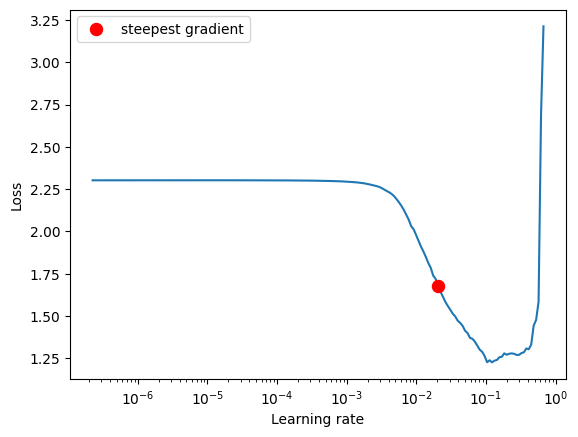

In [24]:
START_LR = 1e-7
model = Model()
model.apply(initialize_parameters)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)


optimizer = optim.Adam(model.parameters(), lr=START_LR)
lr_finder = LRFinder(model, optimizer, criterion)
lr_finder.range_test(train_loader, end_lr=1, num_iter=200)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state


Проверим точность для найденной скорости обучения. Отметим, что найденная скорость - это скорее правильный порядок скорости обучения, нежели чем точное значение. В данном случае порядок можно оценить как $0.1$.

In [25]:
model = Model()
model.apply(initialize_parameters)
model = model.to(device)
criterion = criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.1)

In [26]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, metric, device)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, metric, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%',
    f'| Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 4s
	Train Loss: 0.755 | Train Acc: 71.70% | Val. Loss: 0.618 | Val. Acc: 77.73%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 4s
	Train Loss: 0.596 | Train Acc: 78.53% | Val. Loss: 0.674 | Val. Acc: 74.65%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 4s
	Train Loss: 0.581 | Train Acc: 79.24% | Val. Loss: 0.607 | Val. Acc: 78.85%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 4s
	Train Loss: 0.570 | Train Acc: 79.33% | Val. Loss: 0.604 | Val. Acc: 78.12%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 4s
	Train Loss: 0.565 | Train Acc: 79.77% | Val. Loss: 0.581 | Val. Acc: 79.01%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 4s
	Train Loss: 0.563 | Train Acc: 79.88% | Val. Loss: 0.571 | Val. Acc: 80.73%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 4s
	Train Loss: 0.566 | Train Acc: 80.13% | Val. Loss: 0.559 | Val. Acc: 81.21%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 4s
	Train Loss: 0.569 | Train Acc: 80.04% | Val. Loss: 0.563 | Val. Acc: 80.71%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 4s
	Train Loss: 0.555 | Train Acc: 80.30% | Val. Loss: 0.556 | Val. Acc: 80.45%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 4s
	Train Loss: 0.562 | Train Acc: 80.03% | Val. Loss: 0.598 | Val. Acc: 78.67%


In [27]:
model.load_state_dict(torch.load('best_model.pt'))

test_loss, test_acc = evaluate(model, test_loader, criterion, metric, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.575 | Test Acc: 79.84%


## Разделение модели на блоки и управление ими

В ряде случаев более удобным является описание модели в виде блоков или других составных частей, стыкуемых вместе. Например, ниже показана модель, переписанная в виде двух составных частей: кодировщика признаков `feature_extractor` и слоя принятия решений `fc`. В таком виде моделью проще управлять.

In [28]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(nn.Linear(IMAGE_WIDTH*IMAGE_HEIGH, 64),
                                              nn.ReLU(), 
                                              nn.Linear(64, 64),
                                              nn.ReLU(),)
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.fc(x)
        return x   
model = Model()
model

Model(
  (feature_extractor): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (fc): Linear(in_features=64, out_features=10, bias=True)
)

Например, можно отдельно вызвать `feature_extractor`.

In [29]:
model.feature_extractor

Sequential(
  (0): Linear(in_features=784, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
)

Или можно отдельно получить результат работы модели.

In [30]:
x,y = next(iter(train_loader))
with torch.inference_mode():
    model.eval(); 
    fe = model.feature_extractor(x)
    head =  model.fc(fe)     
    print(fe.shape, head.shape)

torch.Size([64, 64]) torch.Size([64, 10])


> Отметим, что теперь можно скомбинировать полученный `feature_extractor` c новой головной частью модели.
>```python
    m2 = nn.Sequential(model.feature_extractor, nn.Linear(64,32), nn.ReLU(), nn.Linear(32,10))
```

## Оптимизация параметров обучения по блокам

При обучении моделей часто оказывается желательным проведение [настройки параметров обучения](https://pytorch.org/docs/stable/optim.html#module-torch.optim).
Например, в ряде случаев полезным оказывается использование отдельных параметров обучения для экстрактора признаков и его головной части. Этот прием будет еще упомянут в разделе перенос признаков. Тут, однако, тоже его отметим. Прием использования различных скоростей обучения позволяет регулировать интенсивность обучения. Например, если мы ожидаем, что часть нейронной сети предобучена, то для нее скорость обучения должна быть гораздо ниже (если предобученные слои вообще нуждаются в обучении). 

> Часто при использовании предобученных сетей используется гипотеза заключается в том, что ранние слои нейронной сети учатся извлекать более общие признаки, в то время как поздние слои учатся извлекать более специфичные для конкретной задачи признаки. Если это так, то общие признаки, извлекаемые ранними слоями, должны быть полезны для любой задачи, и мы должны изменять их предварительно обученные веса на очень небольшую величину — если вообще должны.

> Дискриминативную тонкую настройку параметров обучения обычно нет необходимости использовать при обучении модели на основе случайно инициализированных весов.


In [31]:
model = Model()
model.apply(initialize_parameters)
model = model.to(device)
criterion = criterion.to(device)

LR = 1e-1;

params = [
          {'params': model.feature_extractor.parameters(), 'lr': LR / 2},
          {'params': model.fc.parameters(), 'lr': LR }
         ]

optimizer = optim.Adam(params, lr=LR)

In [32]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, metric, device)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, metric, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%',
    f' | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 4s
	Train Loss: 0.613 | Train Acc: 77.17%  | Val. Loss: 0.563 | Val. Acc: 80.44%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 4s
	Train Loss: 0.472 | Train Acc: 82.78%  | Val. Loss: 0.460 | Val. Acc: 83.88%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 4s
	Train Loss: 0.448 | Train Acc: 83.92%  | Val. Loss: 0.497 | Val. Acc: 81.47%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 4s
	Train Loss: 0.425 | Train Acc: 84.77%  | Val. Loss: 0.450 | Val. Acc: 85.01%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 4s
	Train Loss: 0.415 | Train Acc: 85.17%  | Val. Loss: 0.422 | Val. Acc: 85.04%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 4s
	Train Loss: 0.403 | Train Acc: 85.44%  | Val. Loss: 0.408 | Val. Acc: 86.44%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 4s
	Train Loss: 0.399 | Train Acc: 85.90%  | Val. Loss: 0.478 | Val. Acc: 83.92%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 4s
	Train Loss: 0.397 | Train Acc: 85.99%  | Val. Loss: 0.417 | Val. Acc: 85.50%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 4s
	Train Loss: 0.389 | Train Acc: 86.04%  | Val. Loss: 0.397 | Val. Acc: 86.52%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 4s
	Train Loss: 0.383 | Train Acc: 86.30%  | Val. Loss: 0.466 | Val. Acc: 83.82%


In [33]:
test_loss, test_acc = evaluate(model, test_loader, criterion, metric, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.505 | Test Acc: 82.55%


## Планировщик скорости обучения

Другим полезным приемом будет использовать [планировщик скорости обучения](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) `learning rate scheduler`. Планировщик скорости обучения динамически изменяет скорость обучения во время обучения модели. 
 
В наиболее простом случае планировщик скорости обучения задается из пакета `torch.optim.lr_scheduler` как одноцикловой планировщик. То есть он имеет только один цикл изменения скорости. 

Ниже показан пример визуализации для 4 типов планировщиков. 

> Обратите внимание, что текущее значение скорости обучения можно получить как `optimizer.param_groups[0]["lr"]`. Аналогичным образом мы его возвращаем после каждого цикла оптимизатора. 



In [34]:
LR_START = 0.1
optimizer = optim.SGD(model.parameters(), lr=LR_START, momentum=0.9)

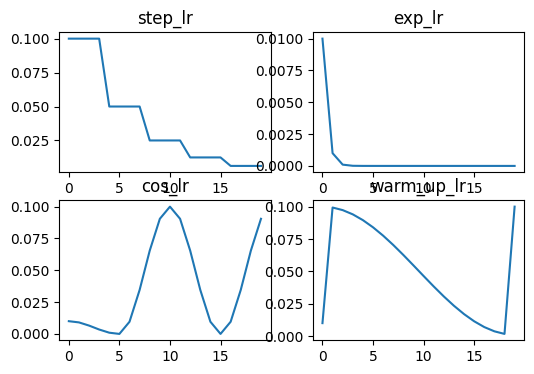

In [35]:
epochs = 20


schedulers = {'step_lr':torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5),
              'exp_lr':torch.optim.lr_scheduler.ExponentialLR(optimizer,  gamma=0.1),              
              'cos_lr':torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0),
              'warm_up_lr':torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 
                                                                   T_0=19, T_mult=1, 
                                                                   eta_min=0.001)}

lrs = np.zeros((len(schedulers), epochs))
fig, axs = plt.subplots(2,2,figsize=(6,4));

with torch.inference_mode():
     
    for j, (k,scheduler) in enumerate(zip(schedulers.keys(), schedulers.values())):

        for i in range(epochs):
            optimizer.step()
            lrs[j,i] = optimizer.param_groups[0]["lr"]
            scheduler.step()
        optimizer.param_groups[0]["lr"]  = 0.01
        axs.ravel()[j].plot(range(epochs),lrs[j]); 
        axs.ravel()[j].set_title(k);


<blockquote>
    
Отметим, что также может быть использован планировщик `ReduceLROnPlateau`, который снижает скорость обучения автоматически при выходе валидации на плато.
    
```python

    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    scheduler = ReduceLROnPlateau(optimizer, 'min')
    for epoch in range(10):
        train(...)
        val_loss = validate(...)
        # Note that step should be called after validate()
        scheduler.step(val_loss)
```

Дополним функцию тренировки новым аргументом `scheduler`.

In [36]:
def train(model, dataloader, optimizer, criterion, metric, scheduler=None,  device = 'cpu'):

    epoch_loss = 0
    epoch_acc  = 0

    model.train()

    for (x, y) in tqdm(dataloader, desc="Training", leave=False):

        x, y = x.to(device), y.to(device)

        optimizer.zero_grad(set_to_none = True)

        y_pred = model(x)

        loss = criterion(y_pred, y)
        acc  = metric( y_pred, y)

        loss.backward()
        
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 1., norm_type= 2)
        
        optimizer.step()                

        epoch_loss += loss.item()
        epoch_acc  += acc.item()
    
    if scheduler != None:
        scheduler.step()
        
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

Проверим работу расписания. 

Следует также отметить, что помимо расписания ниже приведен следующий код:
```python
    max_grad = 10
    for p in model.parameters():
        p.register_hook(lambda grad: torch.clamp(grad, -0.1, max_grad))
```

Такой прием позволяет ограничить значение градиента (`gradient clipping`): `lambda grad: torch.clamp(grad, -0.1, max_grad)`. Прием применяется для всех параметров, так как задан цикл. При этом данный прием записывается как дополнительная функция при расчете градиента. Это реализовано через т.н. `hook`. По средствам метода `register_hook` подобно `callback` каждому параметру ставится дополнительная функция в соответствие.

Отметим, что можно бы было провести `gradient clipping` при помощи встроенной утилиты `torch.nn.utils.clip_grad_norm_`. В функции `train` выше эта строка закомментирована. 

In [37]:
LR_PERIOD = 2
LR_DECAY  = 0.9
LR = 0.1;


model = Model()
model = model.to(device)
criterion = criterion.to(device)

model.apply(initialize_parameters)

max_grad = 10
for p in model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -0.1, max_grad))

optimizer = optim.Adam(model.parameters(), lr=LR)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size = LR_PERIOD, 
                                            gamma     = LR_DECAY)


In [38]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, metric, scheduler)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, metric, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s | LR {optimizer.param_groups[0]["lr"] :.4f}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%',
    f' | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 4s | LR 0.1000
	Train Loss: 0.812 | Train Acc: 70.23%  | Val. Loss: 0.736 | Val. Acc: 74.33%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 4s | LR 0.0900
	Train Loss: 0.764 | Train Acc: 72.90%  | Val. Loss: 0.800 | Val. Acc: 72.27%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 4s | LR 0.0900
	Train Loss: 0.725 | Train Acc: 74.30%  | Val. Loss: 0.700 | Val. Acc: 74.25%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 4s | LR 0.0810
	Train Loss: 0.666 | Train Acc: 76.91%  | Val. Loss: 0.658 | Val. Acc: 77.49%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 4s | LR 0.0810
	Train Loss: 0.633 | Train Acc: 78.01%  | Val. Loss: 0.660 | Val. Acc: 78.66%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 4s | LR 0.0729
	Train Loss: 0.613 | Train Acc: 78.84%  | Val. Loss: 0.618 | Val. Acc: 79.24%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 4s | LR 0.0729
	Train Loss: 0.601 | Train Acc: 79.07%  | Val. Loss: 0.622 | Val. Acc: 79.72%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 4s | LR 0.0656
	Train Loss: 0.618 | Train Acc: 78.54%  | Val. Loss: 0.606 | Val. Acc: 80.41%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 4s | LR 0.0656
	Train Loss: 0.594 | Train Acc: 79.79%  | Val. Loss: 0.660 | Val. Acc: 78.81%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 4s | LR 0.0590
	Train Loss: 0.593 | Train Acc: 79.86%  | Val. Loss: 0.595 | Val. Acc: 80.03%


In [39]:
test_loss, test_acc = evaluate(model, test_loader, criterion, metric, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.602 | Test Acc: 79.40%


<!-- https://pytorch.org/vision/main/auto_examples/transforms/plot_cutmix_mixup.html#sphx-glr-auto-examples-transforms-plot-cutmix-mixup-py
from torchvision.transforms import v2
NUM_CLASSES = 10
alpha  = 0.5

cutmix = v2.CutMix(num_classes=NUM_CLASSES, alpha = alpha)
mixup = v2.MixUp(num_classes=NUM_CLASSES, alpha = alpha)
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])

for images, labels in train_loader:
    images = images.reshape(-1,1,28,28)
    print(f"Before CutMix/MixUp: {images.shape = }, {labels.shape = }")
    images, labels = cutmix_or_mixup(images, labels)
    print(f"After  CutMix/MixUp: {images.shape = }, {labels.shape = }")
    
    targets1, targets2 = 
    loss = alpha * criterion(preds, targets1) + (1 - self.alpha) * criterion(preds, targets2)

    break
    
targets = torch.nonzero(labels).reshape(-1,4)[:,1::2]
    
images = images.reshape(-1,1,28,28)
batch = torchvision.utils.make_grid(images, nrow = int(np.sqrt(images.shape[0])), padding = 0)
vis_batch = batch.data.numpy().transpose((1, 2, 0))*255
plt.imshow(vis_batch); 
plt.axis('off');
plt.show()
images.shape, batch.shape,  vis_batch.shape  

class CutMixCELoss(nn.Module):
    def __init__(self, alpha = 0.5):
        super(CutMixCELoss, self).__init__() 
        self.criterion = nn.CrossEntropyLoss
        self.alpha = alpha

    def farward(self, preds, targets):
        targets1, targets2  = targets
        return self.alpha * self.criterion(preds, targets1)\
            + (1 - self.alpha) * self.criterion(preds, targets2)
            
```python
    from torch.utils.data import default_collate

    def collate_fn(batch):
        return cutmix_or_mixup(*default_collate(batch))
    
    
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn) -->

## Задания

**1.** Проверьте, как влияют те или иные режимы инициализации на качество работы нейронной сети. Например, инициализация постоянными величинами `nn.init.constant_(m.weight, constant_weight)`.

__2.__  В ряде [случаев](https://discuss.pytorch.org/t/tricks-for-being-able-to-use-a-higher-learning-rate/142179) рекомендуется стратегия обучения, когда изначально используется крайне низкая скорость обучения в течение нескольких эпох, чтобы веса модели настроились в нужном направлении. Такие эпохи будут сравнительно бесполезными с точки зрения результата обучения, но повышают стабильность экспериментов. Затем скорость обучения резко увеличивают и начинают плавно снижать. Предполагается, что после первоначальной настройки весов они могут быстро обучиться в нужном направлении. __Предлагается__ реализовать эту стратегию самостоятельно.

__3.__ В ряде [работ](https://openreview.net/pdf?id=B1Yy1BxCZ) рекомендуется вместе с изменением скорости обучения (с ее снижением) [увеличивать размер батча](https://stackoverflow.com/questions/53033556/how-should-the-learning-rate-change-as-the-batch-size-change). __Предлагается__ реализовать эту стратегию обучения самостоятельно. 

> [Иногда](https://ar5iv.labs.arxiv.org/abs/1803.09820) также рекомендуют уменьшать затухание весов с ростом эпохи обучения (параметр `L2` регуляризации — `weight_decay` в оптимизаторах). Если используется параметр `momentum`, то он должен снижаться с увеличением скорости обучения [или циркулировать](https://ar5iv.labs.arxiv.org/abs/1803.09820).

__4.__ Настройка параметров обучения может быть выполнена не только по блокам модели, но и по отдельным параметрам. Например, если используется `SGD with weight_decay`, иногда полезно отключить `weight_decay` для параметра смещения. Это можно сделать следующим образом.
    
```python
    bias_params = [p for name, p in self.named_parameters() if 'bias' in name]
    others = [p for name, p in self.named_parameters() if 'bias' not in name]

    optim.SGD([
                    {'params': others},
                    {'params': bias_params, 'weight_decay': 0}
                ], weight_decay=1e-2, lr=1e-2)
```
> Отметим, что также [в ряде случаев](https://github.com/NVIDIA/DeepLearningExamples/blob/8d8b21a933fff3defb692e0527fca15532da5dc6/PyTorch/Classification/ConvNets/image_classification/training.py)  'weight_decay' не используется для параметров батч-нормализации.

__Предлагается__ проверить качество такого оптимизатора самостоятельно.

__5.__ Иногда в функцию потерь также добавляют параметр [`label_smoothing`](https://paperswithcode.com/method/label-smoothing), выставляя его небольшим. При этом итоговая метка класса формируется как $$ y_s = (1-\eta y) + U[0, \eta/K] $$ где $\eta$ — весовой коэффициент, $K$ — число классов, а $U[0, \eta/K]$ — равномерное распределение. То есть $y_s$ представляет собой вектор, где основной класс имеет значение в диапазоне $(0,1)$, а остаток этого диапазона «размыт» между значениями остальных классов. В таком случае ожидается, что подразумеваемая функция активации $softmax$ не будет выходить в насыщение, что снизит вероятность переобучения слоя принятия решений. Сегодня `label_smoothing` в оригинальной функции потерь, как это показано ниже. __Предлагается__ попробовать использовать эту функцию самостоятельно.

```python 
    nn.CrossEntropyLoss(label_smoothing = ...)
```

# Аугментация набора данных

## Теники аугментации в `PyTorch`

Одним из наиболее действенных приемов регуляризации обучения является расширение выборки обучающих данных. Однако, расширение выборки реальными примерами не всегда возможно. Поэтому возникает желание расширить выборку «вручную». То есть при помощи искусственных приемов. Такой подход к регуляризации называется __[Аугментация данных](https://www.d2l.ai/chapter_computer-vision/image-augmentation.html) (Data Augmentation)__. 

Цель аугментации — создать похожие, но обучающие примеры данных. Для этого используются серии случайных изменений обучающих данных. В результате аугментация позволяет:
* Увеличить размер обучающего набора данных. 
* Случайные изменения обучающих примеров позволяют моделям меньше полагаться на заложенное в ограниченной выборке смещение, тем самым улучшая обобщающую способность модели. 
> Например, мы можем по-разному обрезать изображение, чтобы интересующий нас объект выглядел в разных положениях, тем самым уменьшая зависимость модели от положения объекта. 
* Другими словами, может быть промоделирован разброс условий получения изображений (например, можно менять яркость и цвет, чтобы уменьшить чувствительность модели к цвету). 

В `PyTorch` проблема аугментации для изображений решается при помощи модуля `transforms` из библиотеки `torchvision`. Однако, существуют и внешние библиотеки аугментаций, например [albumentations](https://albumentations.ai/). Ниже показано, как работать с аугментацией данных.

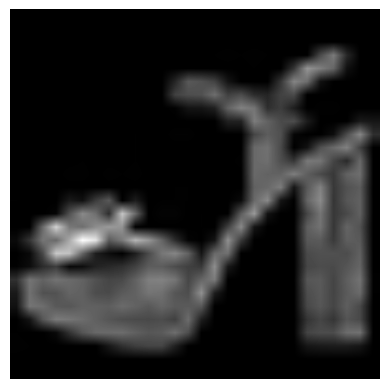

In [53]:
images, _ =  next(iter(train_loader))
images = images.reshape(-1,28,28)
images = images*255
images[0].shape
plt.imshow(images[0], cmap='gray', interpolation='bilinear');  plt.axis('off'); plt.show()

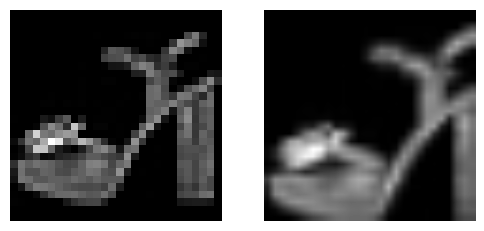

In [54]:
from PIL import Image
from torchvision import transforms 
plt.figure(figsize=(6,3))
to_pil = transforms.ToPILImage()

img = to_pil(images[0])
plt.subplot(121); plt.imshow(img, cmap = 'gray' ); plt.axis('off'); 

center_crops = transforms.Resize(size=32)(img) 
center_crops = transforms.RandomCrop(size=28)(center_crops) 

torch_image = transforms.ToTensor()(center_crops)
plt.subplot(122);  plt.imshow(torch_image[0,:,:], cmap = 'gray', interpolation='bilinear' ); plt.axis('off'); plt.show()


Часто одного типа аугментаций недостаточно. Важно смоделировать сразу набор факторов, влияющих на изображение. Более того, важно заметить, что каждую операцию аугментации часто проводят с заданной случайностью. 

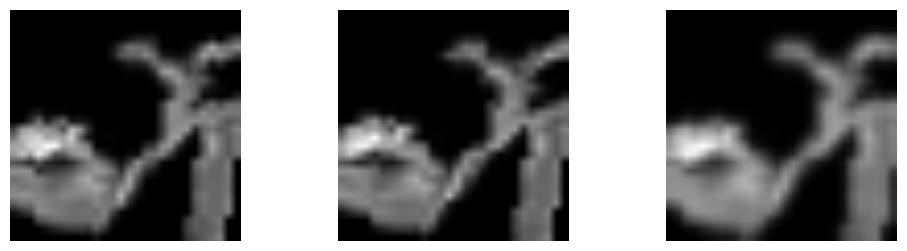

In [55]:
import torchvision.transforms as T

to_pil = T.ToPILImage()
img = to_pil(images[0])

padding = 1
kernel_size = 3

preprocess = T.Compose([
               T.ToTensor(),
               T.Resize(32),
               T.Pad(padding=padding), 
               T.CenterCrop(28),
               T.RandomRotation(degrees=10),
               T.RandomApply([T.GaussianBlur(kernel_size=kernel_size),
                              T.RandomPerspective(distortion_scale=0.6, p=0.3),],p=0.6),
                
                ])

plt.figure(figsize = (12,3))
for subplot in range(131,134):
    plt.subplot(subplot);plt.imshow(preprocess(img)[0,:,:], cmap='gray', interpolation='bilinear'); plt.axis('off')



Как правило, аугментацию проводят (данные генерируются) в процессе работы модели (то есть онлайн). Ниже показан пример добавления показанного выше пайплайна аугментации к загручику данных.

In [56]:
transform_ = lambda x: x.flatten().abs() / 255.0
trasforms = preprocess.transforms + [transform_]
transform=transforms.Compose(trasforms)

In [57]:
train_data = datasets.FashionMNIST('data', train=True,  download=True,  transform=transform)
test_data  = datasets.FashionMNIST('data', train=False, download=True, transform=transform)

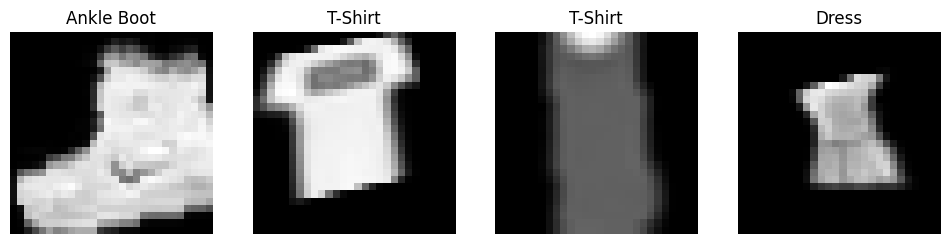

In [45]:
WIDTH = 28
HEIGH = 28
fig, axs = plt.subplots(1,4,figsize=(12,3));
axs[0].imshow(train_data[0][0].view(WIDTH,HEIGH), cmap='gray'); axs[0].set_title(name_classes[train_data[0][1]]); axs[0].axis('off')
axs[1].imshow(train_data[1][0].view(WIDTH,HEIGH), cmap='gray'); axs[1].set_title(name_classes[train_data[1][1]]); axs[1].axis('off')
axs[2].imshow(train_data[2][0].view(WIDTH,HEIGH), cmap='gray'); axs[2].set_title(name_classes[train_data[2][1]]); axs[2].axis('off')
axs[3].imshow(train_data[3][0].view(WIDTH,HEIGH), cmap='gray'); axs[3].set_title(name_classes[train_data[3][1]]); axs[3].axis('off')
plt.show()

Посмотрим на то, как теперь будет выглядеть батч данных.

In [46]:
BATCH_SIZE = 64
trainloader_ = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
testloader_  = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

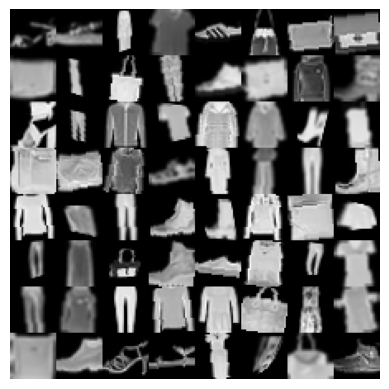

In [47]:
images, _ =  next(iter(trainloader_))
images = images.reshape(-1,1,28,28)
images *= 255
batch = torchvision.utils.make_grid(images, nrow = 8, padding = 0)
vis_batch = batch.numpy().transpose((1, 2, 0))
plt.imshow(vis_batch); 
plt.axis('off');
plt.show()

Отметим, что помимо стандартного пакета аугменатций экосистема `PyTorch` предлагает еще два пакета для расширения этого понятия. 
*  torchvision.transforms.v2 [https://pytorch.org/vision/main/transforms.html](https://pytorch.org/vision/main/transforms.html)
```python
    from torchvision.transforms import v2
    
    transforms = v2.Compose([
    v2.RandomResizedCrop(size=(28, 28), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5], std=[0.225]),
])
```
* Korina - [https://kornia.github.io/ ](https://kornia.github.io/).

```python 
    import kornia

    transform = nn.Sequential(
        kornia.enhance.AdjustBrightness(0.5),
        kornia.enhance.AdjustGamma(gamma=2.),
        kornia.enhance.AdjustContrast(0.7),
    )

    images = transform(images)

```

* albumentation - [https://albumentations.ai/](https://albumentations.ai/).

```python
    import albumentations as A
    from albumentations.pytorch import ToTensorV2
    train_transform = A.Compose(
        [
            A.SmallestMaxSize(max_size=160),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
            A.RandomCrop(height=128, width=128),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
    ]
)
```

А также ряд пакетов для аугментации данных других модальностей.

### Задания

**1.** На самом деле, аугментацию редко используют на тестовой и валидационных выборках. Если такой подход практикуется, скорее всего, это необходимо для увеличения точности тестовой оценки. Однако, аугментация на тестовой выборке должна проводиться более аккуратно, чем на тренировочной. При начальном знакомстве с предметом «Глубокое обучение нейронных сетей» такая аугментация не рекомендуется. Поэтому __предлагаем__ слушателю разработать преобразования `transforms` отдельно для тестовой и отдельно для тренировочной выборок.

**2.** Предлагается сравнить точность обучения моделей для задач обучения с аугментированной и не аугментированной тренировочной выборками. 

__3.__  Одна из главных проблем, связанных с использованием машинного обучения на [непроверенных данных](https://habr.com/ru/companies/wunderfund/articles/794546/) (в продолжительном режиме работы), заключается в риске возникновения т.н. __дрейфа модели__ (или __дрейфа данных__). Дрейф модели — это эффект снижения производительности модели при изменении распределения данных (при долговременном изменении признаков данных) в процессе работы. Например, для изображений камера может загрязняться, что приведет к размытию и появлению шумов типа «соль и перец» на изображениях. Или возникнет __эффект ограниченного набора данных__, то есть в реальных данных появятся/участятся случаи, не учтенные в тренировочных данных в достаточной степени. Например, если система обучена на наборе данных, который собран в течение одного сезона (напр., года), то этот набор данных может оказаться недостаточно полным для последующих годов. Другими словами, в данных появится значительная __нестационарность__. 

В целом проблема дрейфа решается путем постоянного сбора данных и их версионирования, а также путем постоянного обучения модели (непрерывного обучения). Однако, в данном случае предлагается смоделировать возможные эффекты дрейфа данных путем аугментации данных. Проверьте, как это скажется на точности модели.


**4.** При обучении нейронных сетей важно не только обучение в заданных условиях, но и стабильность работы вне зависимости от внешних условий. При разработке и обучении моделей часто упускается из виду такой аспект, как безопасность и устойчивость перед нарушителем, желающего обмануть модель. [Вы можете быть удивлены](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html), обнаружив, что добавление незаметных возмущений к изображению может привести к радикальному изменению производительности модели. Поэтому при обучении модели важно понимать ее потенциальные уязвимости. Тогда можно добавить эти уязвимости в набор аугментации при тренировке модели, чтобы повысить устойчивость к ним. Такой подход называется `Adversarial Attack`. 

Самый простой пример `Adversarial Attack` может заключаться в добавлении к изображениям небольших шумов.  
> Отметим, что более сложная атака заключалась бы в следующем. Зная функцию потерь для модели, можно подобрать шумы так, чтобы их добавление ко входным данным максимизировало бы лосс, а следовательно, градиент значений, проходящих через модель. 

Предлагается слушателю на тестовом наборе данных добавить шумы (например, `torch.randn` или [другие типы](https://secml.readthedocs.io/en/stable/tutorials/06-MNIST_dataset.html#Training-of-the-classifier)) и проследить за точностью модели в зависимости от дисперсии этих шумов (то есть от т.н. `отношения сигнал-шум`).  
> Не забывайте, что у нас изображение нормировано в диапазон $[0,1]$. Поэтому после добавления шумов изображение стоит вернуть в нужный диапазон, например, при помощи `torch.clamp(perturbed_image, 0, 1)`.

__5.__ Также для оценки надежности модели можно проверить ее работу для шумов. Проверим, что для обученной модели можно создать такое распределение нормального шума на входе, что ее выход будет классифицирован как заданное верное число с определенной долей уверенности.

In [48]:
from tqdm.notebook import trange

def imagine_digit(model, digit, n_iterations=50_000):

    model.eval()

    best_prob = 0
    best_image = None

    with torch.no_grad():

        for _ in trange(n_iterations):

            x = torch.randn(BATCH_SIZE, 28, 28).reshape(BATCH_SIZE, 28*28)

            y_pred = model(x)

            preds = F.softmax(y_pred, dim=-1)

            _best_prob, index = torch.max(preds[:, digit], dim=0)

            if _best_prob > best_prob:
                best_prob = _best_prob
                best_image = x[index]

    return best_image, best_prob

In [49]:
DIGIT = 0

best_image, best_prob = imagine_digit(model, DIGIT)

  0%|          | 0/50000 [00:00<?, ?it/s]

Best image probability: 100.00%


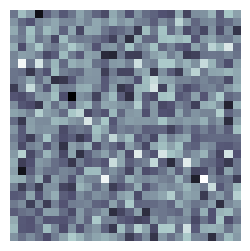

In [50]:
print(f'Best image probability: {best_prob.item()*100:.2f}%')

plt.figure(figsize=(3,3)); plt.imshow(best_image.cpu().numpy().reshape(28,28), cmap='bone')
plt.axis('off');

__Предлгагаем__ проверить то, как аугментация данных влияет не вероятность правильной классификации выборки нормального шума.

>Также __предлагаем__ провести анализ "на ошибки" результатов генерации шумовых изображений.

Часто, помимо того, чтобы просто провести точечную оценку точности, необходимо понять причины ошибок. Для этого полезно провести анализ ошибок на тестовой выборке. Как минимум для задачи классификации можно провести анализ точности по классам.

In [51]:
correct = 0
total   = 0

n_classes = 10
class_correct = torch.zeros(n_classes)
class_total   = torch.zeros(n_classes)

model.eval()
with torch.no_grad():
    for x, y  in testloader:
 
        output = model(x.view(-1,784))
        cls_pred = torch.argmax(output, dim=1)
        
        for idx, (yi, y_hat) in enumerate(zip(y,cls_pred)):

            if y_hat == yi:
                class_correct[yi] += 1
            
            class_total[yi]   += 1


for i in range(n_classes):
    print('Accuracy of %5s : %2d %%' % (
        i, 100 * class_correct[i] / class_total[i]))

NameError: name 'testloader' is not defined

Также проведем визуализацию ошибок путем построения матрицы ошибок.

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(labels, pred_labels, names_classes = np.arange(10)):
    
    fig, ax = plt.subplots(figsize=(6, 6))
    
    cm = confusion_matrix(np.asarray(labels, dtype=int), 
                          np.asarray(pred_labels, dtype=int) )
    
    cm = ConfusionMatrixDisplay(cm, display_labels=names_classes)
    
    cm.plot(values_format='d', cmap='coolwarm', ax=ax)

Теперь соберем лейблы и предсказания в отдельные массивы.

In [ ]:
labels   = []
predicts = []

model.eval()
with torch.no_grad():
    
    for x,y in testloader:

        output = model(x.view(-1,784))
        cls_pred = torch.argmax(output, dim=1)
    
        labels.append(y.tolist())
        predicts.append(cls_pred.tolist())
        
labels = sum(labels,[])
predicts = sum(predicts,[])
# labels   = torch.cat(labels, dim = 0) # make it 1d array
# predicts = torch.cat(predicts, dim = 0) # make it 1d array
    


In [ ]:
plot_confusion_matrix(labels, predicts)

## Задание

__1.__ Предлагается проверить `scores`, помимо самих результатов.

__2.__  Важно проверить, в каких примерах ваша модель ошибается, и убедиться, что это разумные ошибки.

Ниже приведен пример того как это сделать.
Функция `get_predictions` возвращает предсказания модели для заданного набора данных. Она возвращает входные данные (изображение), выходные данные (предсказания модели) и метки истинности. Также код ниже рассчитывает `pred_labels` - предсказанные метки класса.

In [ ]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.inference_mode():

        for (x, y) in iterator:

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

images, labels, probs = get_predictions(model, testloader)

pred_labels = torch.argmax(probs, 1)

Теперь проверим полученные метки на корректность.

In [ ]:
corrects = torch.eq(labels, pred_labels)

Можно просмотреть все примеры предсказаний модели и сохранить в массив все примеры, в которых модель ошиблась.

Затем мы отсортируем неправильные примеры по степени уверенности в них, причем самые уверенные будут стоять на первом месте.

In [ ]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)

Визуализируем 25 самых неверных примеров. К каждому из них будет показан уровень уверенности и метка.

In [ ]:
def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)

Многие из этих цифр неправильной формы, поэтому модели трудно справиться с ними. 

В полученных отрицательных результатах достаточно много двоек. Однако, визуализированы только 25 результатов. Предлагается провести анализ неточности по каждому классу отдельно если задан порог или число наиболее неточных результатов (аналогично анализу по каждому классу выше, но для заданного числа наиболее плохих результатов модели). Также предлагаем подумать слушателю какие методы позволили бы улучшить точность.

__3.__ Иногда полезно посмотреть, как модель отображает классы в результате работы `feature extractor` (`backbone`). Этот прием используется в нескольких целях, например, позволяет визуализировать отображение классов нейронной сетью. Для того чтобы такой прием реализовать, необходимо иногда возвращать результат работы последнего слоя `feature extractor` отдельным выходом нейронной сети. Предлагается слушателю самостоятельно реализовать эту опцию, например, при помощи объявления дополнительного аргумента `ret_fe` метода `forward`.

<details>
<summary>Click here for hint</summary>
```python
    
    IMAGE_WIDTH = 28 
    IMAGE_HEIGH = 28
    
    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(IMAGE_WIDTH*IMAGE_HEIGH, 64)
            self.fc2 = nn.Linear(64, 64)
            self.fc3 = nn.Linear(64, 10)

    
        def forward(self, x, ret_fe = False):
            x = F.relu(self.fc1(x))
            h = F.relu(self.fc2(x))
            x = self.fc3(h)

            if ret_fe:
                return x, h
            return x  #log(softmax(x)) in loss assumed
    
```

__4.__ Ниже приведен пример реализации оценки с использованием дополнительного выхода `intermediates` - выхода представления признаков моделью.

In [ ]:
def get_representations(model, iterator):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():

        for (x, y) in iterator:

            y_pred, h = model(x, ret_fe = True)

            outputs.append(y_pred.cpu())
            intermediates.append(h.cpu())
            labels.append(y)

    outputs = torch.cat(outputs, dim=0)
    intermediates = torch.cat(intermediates, dim=0)
    labels = torch.cat(labels, dim=0)

    return outputs, intermediates, labels

outputs, intermediates, labels = get_representations(model,
                                                     trainloader)

Теперь проведем визуализацию полученных результатов методом главных компонент.

In [ ]:
from sklearn import decomposition
from sklearn import manifold
def get_pca(data, n_components=2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [ ]:
def plot_representations(data, labels, n_images=None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10')
    handles, labels = scatter.legend_elements()
    ax.legend(handles=handles, labels=labels)

In [ ]:
intermediate_pca_data = get_pca(intermediates)
plot_representations(intermediate_pca_data, labels)

Ниже также показан пример визуализации методом `t_sne`.

In [ ]:
def get_tsne(data, n_components=2, n_images=None):
    if n_images is not None:
        data = data[:n_images]
    tsne = manifold.TSNE(n_components=n_components, random_state=0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

In [ ]:
N_IMAGES = 5_000

intermediates_tsne_data = get_tsne(intermediates, n_images=N_IMAGES)
plot_representations(intermediates_tsne_data, labels, n_images=N_IMAGES)

Предлагается проверить визуально качество сепарации данных и качество работы модели в целом в зависимости от сложности модели (например, числа слоев в ней или использования дополнительных параметров, таких как функции активации или применение регуляризаций (батч-норм, аугментация и т.д.).

__5.__ Предлагается провести визуализацию выходов модели и сравнить ее с визуализацией промежуточных результатов. <br> Если допустить, что промежуточные результаты должны исходить не из последнего скрытого слоя, а из более ранних слоев, как это скажется на визуализации?